# Project 2 Regression Challenge
## Daniel Rossetti

# 0 - Problem Statement:

This is report is written from the standpoint of a data science consultant who has been hired by Zillow to prototype a home sale price estimator that can be used by website users to estimate the value of their home.  Home sale data from Ames, Iowa have been provided as a starter set and include information on almost 80 different attributes of the home or the sale itself.  This data will be used to train a linear regression model which will use a subset of these attributes to predict a home sale price.  The model quality will be evaluated against the mean average error of the predictions on the training dataset selected.  The target error is to be within $30,000 of the actual home price on average.  If successful, the methods used to create this prototype model will be employed to predict home values in other areas of the country to understand it's general applicability with the ultimate goal of being rolled out onto the Zillow website for users.

If time allows, this model will also examine the effect of time, indicating a shift in greater housing market trends, on the model.

## <font color = 'red'>Notes:
* <font color = 'red'>Go back and check the metric if it should be mean average percent error or mean average error

# 1 - Import Libraries and Read Data

In [412]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
#from sklearn import metrics

In [344]:
# Read Training Data
train = pd.read_csv('../datasets/train.csv')

# Retrieve the shape of the dataset to evaluate size
print(train.shape)

train.head()

(2051, 81)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [345]:
# Read Test Data
test = pd.read_csv('../datasets/test.csv')

# Retrieve the shape of the dataset to evaluate size
print(test.shape)
test.head()

(878, 80)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


# 2 - Data Pre-processing and Preliminary Model Feature Selection

### Strategy:
* Initial checks and evaluations must be performed on the whole dataset
* Light data cleaning will occur to remove data that are not usable
* Analysis will be performed prior to down-selecting the attributes (columns / features) that will be used in the first model

## 2.1 - Check Dataframe Integrity, Check for Null Values

### 2.1.1 - Check Data Integrity (Data Types)

In [346]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

Most of the features are of the correct data type save for the following which need to be reassigned:
* MS SubClass - The building class is actually a categorical variable and needs to be turned into an object
    * Change this to an object type (convert to string)
* Mo Sold - The month sold is also a categorical variable
    * Change this to an object type (convert to string)
    
Other Categories: <br/>
'Overall Qual' and 'Overall Cond' are technically categorical variables, but as they are discrete numerical variables which effectively establish a quality/condition spectrum, it could be argued that these should be left as numerical datatypes.
* For now, they will be kept as numerical

Some Variables ('Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars') are float values when they likely shoudl be represented as integers.  The code below will investigate what float values if any are present.

In [347]:
# The code below creates a list of items in each catgeory (column) which will have a remainder greater than 0 when divided by 1
#  This will indicate if the number is truly a decimal or if something else is happening.  It's then converted to a set.
print(set([i for i in train['Bsmt Full Bath'] if i % 1 != 0]))
print(set([i for i in train['Bsmt Half Bath'] if i % 1 != 0]))
print(set([i for i in train['Garage Yr Blt'] if i % 1 != 0]))
print(set([i for i in train['Garage Cars'] if i % 1 != 0]))

{nan, nan}
{nan, nan}
{nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan}
{nan}


From this, NaN values (which are technically float64) are causing these columns to be float instead of integer.  Overall, these values are fine, but the null values should now be checked.

Below, 'MS SubClass' and 'Mo Sold' will be converted to objects.

In [348]:
# Convert MS SubClass and Mo Sold to objects, using list comprehension
train['MS SubClass'] = [str(i) for i in train['MS SubClass']]
train['Mo Sold'] = [str(i) for i in train['Mo Sold']]
test['MS SubClass'] = [str(i) for i in test['MS SubClass']]
test['Mo Sold'] = [str(i) for i in test['Mo Sold']]

print(train[['MS SubClass', 'Mo Sold']].info())
print(test[['MS SubClass', 'Mo Sold']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MS SubClass  2051 non-null   object
 1   Mo Sold      2051 non-null   object
dtypes: object(2)
memory usage: 32.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MS SubClass  878 non-null    object
 1   Mo Sold      878 non-null    object
dtypes: object(2)
memory usage: 13.8+ KB
None


### 2.1.2 - Check for Null Values, Drop Affected Columns

In [349]:
# There are about 80 columns, make a dataframe so we can filter only those columns with no null values

# Create a dataframe from the summed isnull() results for the train and test data
train_nulls = pd.DataFrame(train.isnull().sum())
test_nulls = pd.DataFrame(test.isnull().sum())

# Bring these dataframes together into a new dataframe
nulls = pd.DataFrame()
nulls['train'], nulls['test'] = train_nulls, test_nulls        

# Make percent columns so it's easier to decipher impact on dataset
nulls['train_pcnt'], nulls['test_pcnt'] = nulls['train'] / train.shape[0] * 100, nulls['test'] / test.shape[0] * 100

# Filter the dataframe to show only the columns in each with null values
nulls[(nulls['train'] != 0) | (nulls['test'] != 0)].sort_values('train', ascending = False)

,train,test,train_pcnt,test_pcnt
Pool QC,2042,874.0,99.561190,99.544419
Misc Feature,1986,837.0,96.830814,95.330296
Alley,1911,820.0,93.174061,93.394077
Fence,1651,706.0,80.497318,80.410023
Fireplace Qu,1000,422.0,48.756704,48.063781
Lot Frontage,330,160.0,16.089712,18.223235
Garage Finish,114,45.0,5.558264,5.125285
Garage Qual,114,45.0,5.558264,5.125285
Garage Cond,114,45.0,5.558264,5.125285
Garage Yr Blt,114,45.0,5.558264,5.125285


Some catageories are substantially under-populated and should be removed.  Those with null counts exceeding 10% of the data, will be eliminated (dropped).  Smaller amounts of null values in each dataframe may be acceptable depending on which featuers are chosen for the selected model(s).  They will be dropped later if needed.

The above dataframe can be filtered to yield the columns that need to be removed.

In [350]:
train.shape

(2051, 81)

In [351]:
# Filter the "nulls" dataframe on the 10% criteria
drop_nulls = nulls[(nulls['train_pcnt'] >= 10) | (nulls['test_pcnt'] >= 10)].sort_values('train', ascending = False)

# Make a variable which is a list (index's are their own objects) of the columns matching the above criteria.
drop_cols = list(drop_nulls.index)
drop_cols

['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Fireplace Qu', 'Lot Frontage']

In [352]:
# Drop columns from both training and test data:
train.drop(columns = drop_cols, inplace = True);
test.drop(columns = drop_cols, inplace = True);

## 2.2 - First-Pass Evaluation of Feature Importance

### 2.2.1 - Correlation with Sales Price
The correlation method will likely provide some quick insight as to which columns have the biggest impact (from a quantitative perspective) on the home sale price.

The source below establishes correlations with magnitudes greater than 0.4 to be "moderate" correllations.  A correlation method will be run on train data, and correlation coefficients will be provided relative to the sale price.  Only features with correaltion coefficient magnitudes greater than 0.4 (meaning > 0.4 OR < -0.4) will be identified.

**NOTE: This will only work for numerical variables as the data currently stand**

https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717-Module9-Correlation-Regression/PH717-Module9-Correlation-Regression4.html

In [353]:
# Run correaltion method on train dataset, selecting the 'SalePrice' column
sale_pr_corr = train.corr()['SalePrice']

# Filter coefficients that are 'moderate' or stronger
sale_pr_corr[(sale_pr_corr >= 0.4) | (sale_pr_corr <= -0.4)]

# Define list of features from the index to eventually check for colinearity in a correlation matrix
prelim_features = sale_pr_corr[(sale_pr_corr >= 0.4) | (sale_pr_corr <= -0.4)].index

In [354]:
sale_pr_corr.sort_values()

PID               -0.255052
Enclosed Porch    -0.135656
Kitchen AbvGr     -0.125444
Overall Cond      -0.097019
Id                -0.051398
Bsmt Half Bath    -0.045328
Low Qual Fin SF   -0.041594
Yr Sold           -0.015203
Misc Val          -0.007375
BsmtFin SF 2       0.016255
Pool Area          0.023106
3Ssn Porch         0.048732
Screen Porch       0.134581
Bedroom AbvGr      0.137067
Bsmt Unf SF        0.190210
2nd Flr SF         0.248452
Half Bath          0.283001
Bsmt Full Bath     0.283662
Lot Area           0.296566
Wood Deck SF       0.326490
Open Porch SF      0.333476
BsmtFin SF 1       0.423519
Fireplaces         0.471093
TotRms AbvGrd      0.504014
Mas Vnr Area       0.512230
Garage Yr Blt      0.533922
Full Bath          0.537969
Year Remod/Add     0.550370
Year Built         0.571849
1st Flr SF         0.618486
Total Bsmt SF      0.628925
Garage Cars        0.648220
Garage Area        0.650270
Gr Liv Area        0.697038
Overall Qual       0.800207
SalePrice          1

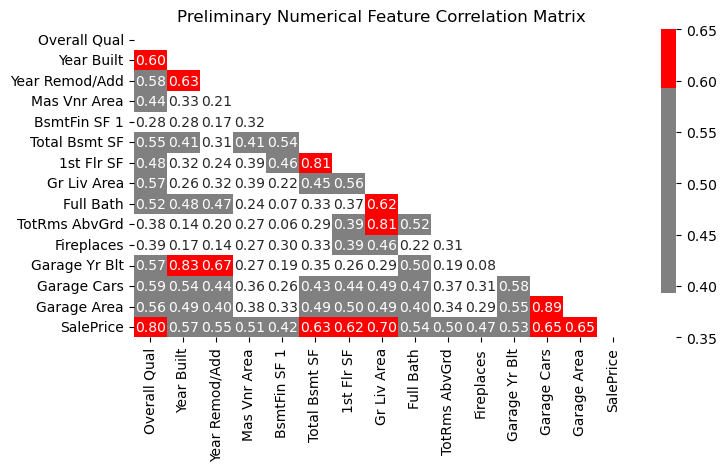

In [355]:
# Plot the correlation map between features

import matplotlib.colors

#this souce needs to be cited!!!!!
cmap2 = matplotlib.colors.ListedColormap(['white','white','white','gray','gray','gray','gray','gray','gray',
                                  'gray','gray','gray','gray','gray','gray','gray',
                                  'gray','red','red','red', 'red'])

# Show onlt bottom left of heatmap
# From Lesson 1.07 - # This code is taken with minor modifications from https://seaborn.pydata.org/generated/seaborn.heatmap.html
mask = np.zeros_like(train[prelim_features].corr())
mask[np.triu_indices_from(mask)] = True


plt.figure(figsize=(8,4))
plt.title('Preliminary Numerical Feature Correlation Matrix')
sns.heatmap(train[prelim_features].corr(),
            annot = True, 
            vmin = 0.35, vmax = .65,
            fmt='.2f', 
            cmap = cmap2, 
            mask = mask);

# Source for "fmt='.2f'":  https://stackoverflow.com/questions/54506626/how-to-understand-seaborns-heatmap-annotation-format

# This is from code I wrote for another program, but I'm not sure where I got the sources from:  
# use the code here, and these sources to cobble something together.
#  Source:  https://stackoverflow.com/questions/38836154/discrete-legend-in-seaborn-heatmap-plot
#  Source:  https://matplotlib.org/stable/gallery/color/named_colors.html
#  Source:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html
#  Source:  https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.colorbar


# sns.heatmap(df.corr(),annot=True,fmt='.2f',cmap=cmap2,vmin=-1, vmax=1, annot_kws={"size":6}) #write your code here
# plt.title('Correlation Coefficients Above/Below +/-0.7')
# plt.show()




In [356]:
prelim_features

Index(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area',
       'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'SalePrice'],
      dtype='object')

In [357]:
set(train.corr().index) - set(prelim_features)

{'2nd Flr SF',
 '3Ssn Porch',
 'Bedroom AbvGr',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Bsmt Unf SF',
 'BsmtFin SF 2',
 'Enclosed Porch',
 'Half Bath',
 'Id',
 'Kitchen AbvGr',
 'Lot Area',
 'Low Qual Fin SF',
 'Misc Val',
 'Open Porch SF',
 'Overall Cond',
 'PID',
 'Pool Area',
 'Screen Porch',
 'Wood Deck SF',
 'Yr Sold'}

#### 2.2.1.1 - Numerical Feature Selection

Check for colinearity:  Examine correlations above 0.6 ("strong" correlations) above between features that are not the target.  Where features are colinear, choose the better one to use in the model and list the rationale.
1. Year Built vs. Overall Qual:  Newer house, better quality.
    * USE QUALITY - Quality seems to track better with SalePrice
2. Year Built vs. Year Remod/Add:  Makes sense that these would correlate as they may be the same number since Year Remod/Add defaults ot the build date if there was nothing added or remodeled
    * USE YEAR REMOD/ADD - Lower correlation with garage built (though still high)
3. Year Built vs. Garage Yr Built:  High correlation would suggest that many times, the garage is built with the house
    * DON'T USE GARAGE YR BUILT - Garage Yr Built may not be a very useful feature in this model.  Garage Cars is a better feature to use if you want to limit the number of garage features since it correlates better with sale price
4. Year Remod/Add vs. Garage Yr Built:  Lower but still strong correlation between the remodel data and the garage build.  Would suggest that many house additions were actually garages
    * USE YEAR REMOD/ADD - Stated previously
5. 1st Flr SF vs. Total Basement SF:  It makes sense that the first floor and basement have approximately the same sqaure footage.  Basement square footage correlates a bit better with sale price.
    * USE Total Basement SF:  Later, Gr Liv Area is a bette measure of home sqaure footage.  Basement is not included in this measure and will act as a unique basement feature.
6. GR Liv Area vs. Full Bath:  It makes sense that these would correlate.  Not clear on whether one or the other should be used
    * TBD
7. GR Liv Area vs. TotRms AbvGrd:  Very strong correlation, preference would be to keep square footage, especially since it correlates better with sale price (0.7 vs 0.5 correlation coefficients)
    * Use Gr Liv Area
8. Garage Area and Garage Cars:  More cars, more area.
    * Use Garage Area because correaltion with sale price is equivalent to that of the number of garage cars but keeps with the square footage theme above
    
Review the remaining features which have correlations magnitudes above 0.4 relative to the target variable, sale price.
* BsmtFin SF 1 - DO NOT USE:  This is only for a type 1 basement, and seems redundnat to total basement square footage (conceptually if no numerically)
* Full Bath - DO NOT USE:  This is too strongly correlated with above grade sqaure footage which is conceptually a better metric
* Mas Vnr Area - MAYBE USE:  Masonry could be indicative of a more expensive house.  Compare against other features later
* Fireplaces - MAYBE USE:  Fireplaces could be indicative of a more expensive house.  Compare against other features later

List of numerical features to be considered:
* Overall Quality
* Year Remod/Add
* Total Basement SF
* Gr Liv Area
* Garage Area
* Mas Vnr Area (MAYBE)
* Fireplaces (MAYBE)


DO NOT USE:
* Garage Yr Blt
* 1st Flr SF
* Garage Cars
* TotRms AbvGrd
* Year Built
* BsmtFin SF 1
* Full Bath

Remaining Numerical Variables:


* 2nd Flr SF - DO NOT USE - total SF is a better metric
* 3Ssn Porch - MAYBE
* Bedroom AbvGr - MAYBE - could be redundant with Total SF
* Bsmt Full Bath - MAYBE - not all basements have bathrooms
* Bsmt Half Bath - MAYBE - not all basements have bathrooms
* Bsmt Unf SF - DO NOT USE - Redundant with total basement SF
* BsmtFin SF 2 - DO NOT USE - Only for a type 2 basement and redundant with total basement SF
* Enclosed Porch - MAYBE
* Half Bath - DO NOT USE - Same reason as full bathrooms above
* Id - DO NOT USE - this is just an identifier for each house and is not a real feature
* Kitchen AbvGr - MAYBE
* Lot Area - USE THIS! - this should indicate how much land is attached to said home
* Low Qual Fin SF - Maybe?  This could be a modifier or possibly a feature could be made from this (like a percentage of the total square feet)
* Misc Val - MAYBE - But, likely not a good candidate of a first pass model
* Open Porch SF - MAYBE
* Overall Cond - MAYBE - Seems redundant with overall quality
* PID -  DO NOT USE - this is just an identifier for each house and is not a real feature
* Pool Area - USE THIS! - Everybody loves a pool!
* Screen Porch - MAYBE
* Wood Deck SF - USE THIS! - Decks should add value
* Yr Sold - USE THIS!  Might be needed for economic conditions given the timeframe being right around the housing bubble.

### 2.2.2 Other Numerical Features
Want to include something from each of the main home feature categories (kitchen, driveway, general, basement, garage, etc.)

<font color = 'red'> TALK ABOUT CONDITION REMAINING ENCODED AS A NUMBER

### 2.2.3 - Categorical Variable Selection Discussion and Encoding

The remaining ___ insert number here __ features are categorical in nature due to tehhir object type.

Of those, many were considered for inclusion in this model, however, as most will need to be one-hot encoded, the number of feauters will dramatically increase as some of these features have a high number of unique values.  

The target is to keep the total number of featuers at or below the square root of the total number of samples.  With a total number of samples at 2051, this will have our maximum number of features at 45.

Since all features cannot ___ easily ___ be one-hot encoded and correlated to the sale price, practical decisions were made on the relevance of each catgorical variable.  One thing that was considered is general category of each variable which specifically refers to which part of the 'home' the variable concerns such as the kitchen, deck, basement, garage, general home, and even some time based variables.  Part of the selection philosophy was to include variables from as many of these categories as possible in order to have a holistic representation of all aspects which could influence the home value (and therefore the sale price).  Even from this, some categories had to be excluded in favor of features which are reasonably perceived to be of higher relevance to the home value.

The categories below were selected as initial model features and are broken down into which are one-hot encoded, and which are number encoded.  These will be encoded in a subsequent section.

Selected features which must be one-hot encoded:
* 'Utilities'
* 'Neighborhood'
* 'Bldg Type'
* 'House Style'
* 'Paved Drive'

Features representing a spectrum of quality or condition which could be encoded as numbers with higher numbers representing higher quality:
* 'Exter Cond'

The follwoing features would have been selected, however, with all above features, the 45 feature limit will be exceeded unless these are excluded.
* 'Heating QC'
* 'Kitchen Qual'


### 2.2.4 - Initial Data Dictionary and Feature Selection Information

This table combines the selection of numerical and catgeorical variables

Extended feature count represents the final feature count after encoding (one-hot or other)


| Var_name         | dtype   | Ext. Ft. Count | Codebook / Data Dictionary:                                                            | Category | Rationale            |
|------------------|---------|----------------|----------------------------------------------------------------------------------------|----------|----------------------|
|  'Total Bsmt SF' | float64 | 1              | TotalBsmtSF: Total square feet of basement area                                        | Basement | High Corr.           |
|  'Garage Area'   | float64 | 1              | GarageArea: Size of garage in square feet                                              | Garage   | High Corr.           |
|  'Lot Area'      | int64   | 1              | LotArea: Lot size in square feet                                                       | Lot      | Practical Importance |
|  'Overall Qual'  | int64   | 1              | OverallQual: Overall material and finish quality                                       | General  | High Corr.           |
| 'Year Remod/Add' | int64   | 1              | YearRemodAdd: Remodel date (same as construction date if no remodeling or   additions) | Time     | Mod Corr             |
| 'Gr Liv Area'    | int64   | 1              | GrLivArea: Above grade (ground) living area square feet                                | General  | High Corr.           |
|  'Bedroom AbvGr' | int64   | 1              | Bedroom: Number of bedrooms above basement level                                       | Bedroom  | Practical Importance |
|  'Wood Deck SF'  | int64   | 1              | WoodDeckSF: Wood deck area in square feet                                              | Deck     | Practical Importance |
|'Pool Area'       | int64   | 1              | PoolArea: Pool area in square feet                                                     | Pool     | Practical Importance |
|  'Misc Val'      | int64   | 1              | MiscVal: $Value of miscellaneous feature                                               | Other    | Direct Value Measure |
|  'Yr Sold'       | int64   | 1              | YrSold: Year Sold                                                                      | Time     | Time Sensitivity     |
| 'Neighborhood'   | object  | 27             | Neighborhood: Physical locations within Ames city limits                               | Location | Practical Importance |
|  'Bldg Type'     | object  | 4              | BldgType: Type of dwelling                                                             | General  | Practical Importance |
| 'Exter Cond'     | object  | 1              | ExterCond: Present condition of the material on the exterior                           | Exterior | Practical Importance |
|  'Paved Drive'   | object  | 2              | PavedDrive: Paved driveway                                                             | Driveway | Practical Importance |

Codebook / Data Dictionary Entries Taken Direct from the Kaggle Competition Site:  https://www.kaggle.com/competitions/dsir-320-project-2-regression-challenge/data

### 2.2.5 - Creating the Initial Model Dataframe

Prior to encoding, a dataframe with all features data must be made.

In [358]:
# Create a list of the desired features

features_init = ['SalePrice',
                 'Total Bsmt SF',
                 'Garage Area',
                 'Lot Area',
                 'Overall Qual',
                 'Year Remod/Add',
                 'Gr Liv Area',
                 'Bedroom AbvGr',
                 'Wood Deck SF',
                 'Pool Area',
                 'Misc Val',
                 'Yr Sold',
                 'Neighborhood',
                 'Bldg Type',
                 'Exter Cond',
                 'Paved Drive']

In [359]:
init_data = train[features_init]

In [360]:
init_data.head()

,SalePrice,Total Bsmt SF,Garage Area,Lot Area,Overall Qual,Year Remod/Add,Gr Liv Area,Bedroom AbvGr,Wood Deck SF,Pool Area,Misc Val,Yr Sold,Neighborhood,Bldg Type,Exter Cond,Paved Drive
0,130500,725.0,475.0,13517,6,2005,1479,3,0,0,0,2010,Sawyer,1Fam,TA,Y
1,220000,913.0,559.0,11492,7,1997,2122,4,0,0,0,2009,SawyerW,1Fam,TA,Y
2,109000,1057.0,246.0,7922,5,2007,1057,3,0,0,0,2010,NAmes,1Fam,Gd,Y
3,174000,384.0,400.0,9802,5,2007,1444,3,100,0,0,2010,Timber,1Fam,TA,Y
4,138500,676.0,484.0,14235,6,1993,1445,3,0,0,0,2010,SawyerW,1Fam,TA,N


#### 2.2.5.1 - One Hot Encoding Variables

In [361]:
# Print the unique values for each category and make sure that the data look correct
for i in ['Neighborhood', 'Bldg Type', 'Paved Drive']:
    print(init_data[i].unique())

['Sawyer' 'SawyerW' 'NAmes' 'Timber' 'Edwards' 'OldTown' 'BrDale'
 'CollgCr' 'Somerst' 'Mitchel' 'StoneBr' 'NridgHt' 'Gilbert' 'Crawfor'
 'IDOTRR' 'NWAmes' 'Veenker' 'MeadowV' 'SWISU' 'NoRidge' 'ClearCr'
 'Blmngtn' 'BrkSide' 'NPkVill' 'Blueste' 'GrnHill' 'Greens' 'Landmrk']
['1Fam' 'TwnhsE' 'Twnhs' '2fmCon' 'Duplex']
['Y' 'N' 'P']


In [362]:
# One hot encode categorical variables which are not going to be encoded as numbers.
# Note, after some checking, drop_first appears to drop the desired columns for Bloomington, Single Family Homes, and Unpaved Driveways
init_data = pd.get_dummies(columns=['Neighborhood', 'Bldg Type', 'Paved Drive'],
               data = init_data,
              drop_first= True
              )

In [363]:
init_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SalePrice             2051 non-null   int64  
 1   Total Bsmt SF         2050 non-null   float64
 2   Garage Area           2050 non-null   float64
 3   Lot Area              2051 non-null   int64  
 4   Overall Qual          2051 non-null   int64  
 5   Year Remod/Add        2051 non-null   int64  
 6   Gr Liv Area           2051 non-null   int64  
 7   Bedroom AbvGr         2051 non-null   int64  
 8   Wood Deck SF          2051 non-null   int64  
 9   Pool Area             2051 non-null   int64  
 10  Misc Val              2051 non-null   int64  
 11  Yr Sold               2051 non-null   int64  
 12  Exter Cond            2051 non-null   object 
 13  Neighborhood_Blueste  2051 non-null   uint8  
 14  Neighborhood_BrDale   2051 non-null   uint8  
 15  Neighborhood_BrkSide 

#### 2.2.5.2 - Number Encoding Variables

In [364]:
# Check the exact names of values for exterior condition:
init_data['Exter Cond'].unique()

array(['TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [365]:
# Encode values 1 through 5 based on the condition into the 'Exter Cond' column, 5 being Excellent and 1 being Poor
init_data['Exter Cond'] = [5 if i == 'Ex' else 4 if i == 'Gd' else 3 if i == 'TA' else 2 if i == 'Fa' else 1 for i in init_data['Exter Cond']]

In [366]:
# Check that all columns are a number of some sort:
init_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SalePrice             2051 non-null   int64  
 1   Total Bsmt SF         2050 non-null   float64
 2   Garage Area           2050 non-null   float64
 3   Lot Area              2051 non-null   int64  
 4   Overall Qual          2051 non-null   int64  
 5   Year Remod/Add        2051 non-null   int64  
 6   Gr Liv Area           2051 non-null   int64  
 7   Bedroom AbvGr         2051 non-null   int64  
 8   Wood Deck SF          2051 non-null   int64  
 9   Pool Area             2051 non-null   int64  
 10  Misc Val              2051 non-null   int64  
 11  Yr Sold               2051 non-null   int64  
 12  Exter Cond            2051 non-null   int64  
 13  Neighborhood_Blueste  2051 non-null   uint8  
 14  Neighborhood_BrDale   2051 non-null   uint8  
 15  Neighborhood_BrkSide 

In [367]:
# There are two null values that should be investigated:
init_data[(pd.isna(init_data['Total Bsmt SF']) == True) | (pd.isna(init_data['Garage Area']) == True) ]

,SalePrice,Total Bsmt SF,Garage Area,Lot Area,Overall Qual,Year Remod/Add,Gr Liv Area,Bedroom AbvGr,Wood Deck SF,Pool Area,...,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Paved Drive_P,Paved Drive_Y
1327,79000,NaN,280.0,5940,4,1950,896,2,0,0,...,0,0,0,0,0,0,0,0,0,1
1712,150909,859.0,NaN,9060,5,1999,1828,3,174,0,...,0,0,0,0,0,0,0,0,0,1


In [368]:
# It may be safe to assume that if no value is collected for basement or garage square feet, then neither exist and would be 0.

# Fill the NaN valuse with 0
init_data.fillna(0, inplace=True)

#### 2.2.5.3 - Check for Colinearity in Initial Dataframe with Encoded Columns

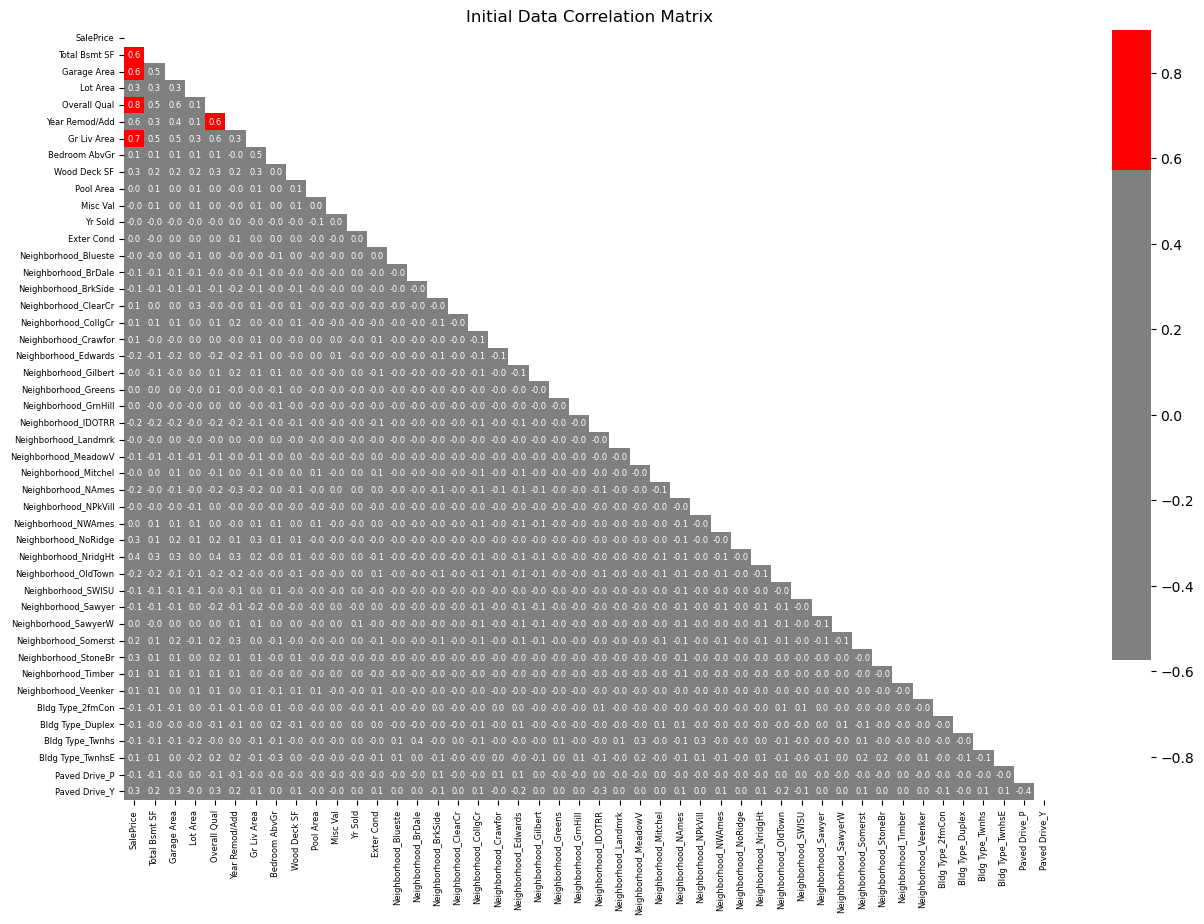

In [369]:
# Plot the correlation map between features

import matplotlib.colors

#this souce needs to be cited!!!!!
cmap2 = matplotlib.colors.ListedColormap(['white','white','white','white','gray','gray','gray','gray','gray','gray',
                                  'gray','gray','gray','gray','gray','gray','gray',
                                  'gray','red','red','red', 'red'])

# Show only bottom left of heatmap
# From Lesson 1.07 - # This code is taken with minor modifications from https://seaborn.pydata.org/generated/seaborn.heatmap.html
#  'annot_kws={"size":8}' from:  https://stackoverflow.com/questions/33104322/auto-adjust-font-size-in-seaborn-heatmap
mask = np.zeros_like(init_data.corr())
mask[np.triu_indices_from(mask)] = True


plt.figure(figsize=(15, 10))
plt.title('Initial Data Correlation Matrix')
plt.xticks(size = 6)
plt.yticks(size = 6)
sns.heatmap(init_data.corr(),
            annot = True, 
            vmin = -0.9, vmax = .9,
            annot_kws={"size":6},
            fmt='.1f', 
            cmap = cmap2, 
            mask = mask);

Above, no columns correlate with each other (save for the target) with a correlation coefficient above 0.6.  Thus, save for a few moderate correrlations, there is minimal colinearity.

# 3 - Initial Modeling

In [370]:
# Create train and test datasets!

# First, create X and y from the data above
X_init = init_data.drop(columns = 'SalePrice')
y_init = init_data['SalePrice']

# Run train test split:
X_init_train, X_init_test, y_init_train, y_init_test = train_test_split(X_init, y_init, random_state=0, test_size=0.3)

In [371]:
# Run initial LR model
lr_init = LinearRegression()

lr_init.fit(X_init_train, y_init_train)

LinearRegression()

In [372]:
# Get the R2 scores for the training and test datasets:
lr_init.score(X_init_train, y_init_train), lr_init.score(X_init_test, y_init_test)

(0.8621075729746097, 0.7975617855484634)

In [373]:
# Get the cross validation score for the training dataset
cross_val_score(lr_init, X_init_train, y_init_train)

array([0.83661378, 0.85716032, 0.79836608, 0.85400689, 0.76991106])

In [374]:
# Create predictions for the train and test datasets:
preds_train = lr_init.predict(X_init_train)
preds_test = lr_init.predict(X_init_test)

In [375]:
# Mean absolute error:
mean_absolute_error(y_init_train, preds_train), mean_absolute_error(y_init_test, preds_test)

(19786.240563288073, 20797.431808668072)

In [376]:
# Root mean sqaured error for training and test data:
mean_squared_error(y_init_train, preds_train, squared=False), mean_squared_error(y_init_test, preds_test, squared=False)

(29491.756965162534, 35451.87017486849)

In [377]:
# Create residual datasets
resid_init_train, resid_init_test = (y_init_train - preds_train), (y_init_test - preds_test)

In [378]:
# Get basic stats on the residuals
resid_init_train.describe()

count    1.435000e+03
mean     7.370266e-11
std      2.950204e+04
min     -2.343643e+05
25%     -1.408952e+04
50%     -6.514829e+02
75%      1.312520e+04
max      2.166684e+05
Name: SalePrice, dtype: float64

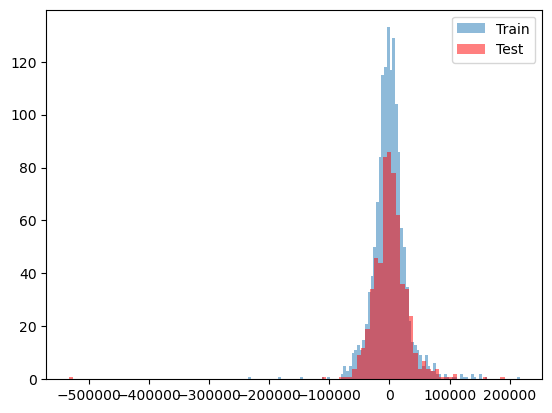

In [379]:
# PLot a histogram of the residuals
#  Source for legend:  https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
#  Source for legend labels:  https://stackoverflow.com/questions/59346731/no-handles-with-labels-found-to-put-in-legend
plt.hist(resid_init_train, bins = 100, alpha = 0.5, label = 'Train');
plt.hist(resid_init_test, color = 'red', bins = 100, alpha = 0.5, label='Test');
plt.legend();

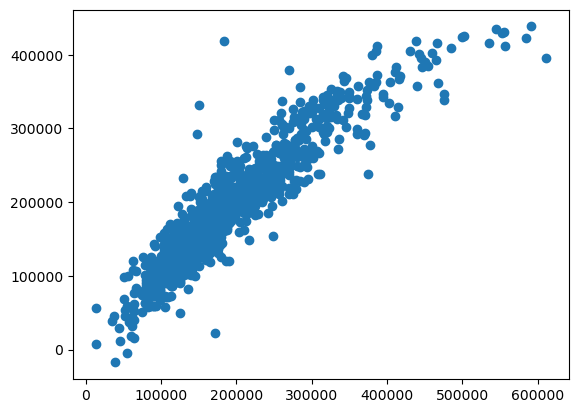

In [380]:
plt.scatter(y_init_train, preds_train);

# 4 - Model Refinement Through Additional Feature Engineering

A fucntion should be created to quickly run all code that is commonly run for a linear regression model.

This function will take in the X matrix and the target array, and will return a dataframe with all metrics associated with the Linear Regression fit.

In [381]:
# Create a funciton to make train test splits, fit the model, and all that stuff:

def split_fit_metric_frame(X, y, mod_name):
    # Create a train and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
    
    # Create local Linear Regression instance:
    lr = LinearRegression()
    
    # Fit the function:
    lr.fit(X_train, y_train)
    
    # Create predictions:
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)

    # Get R2 train & test scores:
    r2_train = lr.score(X_train, y_train)
    r2_test = lr.score(X_test, y_test)
    
    # Get train & test RMSE:
    rmse_train = mean_squared_error(y_train, pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, pred_test, squared=False)
    
    # Get mean absolute error:
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_test = mean_absolute_error(y_test, pred_test)
    
    # Get cross validation scores and their mean
    cv_train = cross_val_score(lr, X_train, y_train, )
    cv_train_mean = cross_val_score(lr, X_train, y_train).mean()
    
#     print(f'R2_train: {round(r2_train, 4)}')
#     print(f'R2_test: {round(r2_test, 4)}')
#     print(f'RMSE_train: {round(rmse_train)}')
#     print(f'RMSE_test: {round(rmse_test)}')
#     print(f'mae_train: {round(mae_train)}')
#     print(f'mae_test: {round(mae_test)}')
    
#     # Sounce for numpy.around():  https://numpy.org/doc/stable/reference/generated/numpy.around.html
#     print(f'cv_train: {np.around(cv_train, 4)}')
#     print(f'cv_train_mean: {np.around(cv_train_mean, 4)}')
    
    items = ['R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'mae_train', 'mae_test', 'cv_train_mean', 'cv_train_1', 'cv_train_2', 'cv_train_3', 'cv_train_4', 'cv_train_5',]
    variables = [round(r2_train, 4), 
                 round(r2_test, 4), 
                 round(rmse_train), 
                 round(rmse_test), 
                 round(mae_train), 
                 round(mae_test), 
                 np.around(cv_train_mean, 4),
                 np.around(cv_train[0], 4),
                 np.around(cv_train[1], 4),
                 np.around(cv_train[2], 4),
                 np.around(cv_train[3], 4),
                 np.around(cv_train[4], 4),
                ]
    
    # Create global variables in the background so they can be called later:
    #  Source:  Special thanks to Alanna Besaw for help finding the globals() function!
    globals()[f'X_train_{mod_name}'] = X_train
    globals()[f'X_test_{mod_name}'] = X_test
    globals()[f'y_train_{mod_name}'] = y_train
    globals()[f'y_test_{mod_name}'] = y_test    
    globals()[f'preds_train_{mod_name}'] = preds_train    
    globals()[f'preds_test_{mod_name}'] = preds_test    
    
    # Return a dataframe with all the metrics above!
    return pd.DataFrame(variables, index = items, columns = [f'{mod_name}'])

    

In [382]:
# Test function on the model already made and compare results:
model_metrics = split_fit_metric_frame(X_init, y_init, 'mod').copy()
model_metrics

,mod
R2_train,0.8621
R2_test,0.7976
RMSE_train,29492.0000
RMSE_test,35452.0000
mae_train,19786.0000
mae_test,20797.0000
cv_train_mean,0.8232
cv_train_1,0.8366
cv_train_2,0.8572
cv_train_3,0.7984


In [383]:
X_train_mod

,Total Bsmt SF,Garage Area,Lot Area,Overall Qual,Year Remod/Add,Gr Liv Area,Bedroom AbvGr,Wood Deck SF,Pool Area,Misc Val,...,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Paved Drive_P,Paved Drive_Y
1439,931.0,0.0,5400,7,2006,1027,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1419,1008.0,0.0,6000,5,1950,1522,4,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1446,1105.0,308.0,10454,6,1957,1105,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1
539,485.0,255.0,5310,6,2003,1635,2,394,0,0,...,0,0,0,0,0,0,0,0,0,1
1903,963.0,564.0,12435,7,2001,1792,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,894.0,400.0,9450,4,1954,894,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1731,918.0,264.0,7892,6,1979,918,2,28,0,0,...,0,0,0,0,0,0,0,1,0,1
763,870.0,576.0,8846,5,1996,914,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
835,1286.0,704.0,12585,8,1993,2799,3,432,0,0,...,0,0,0,0,0,0,0,0,0,1


## 4.1 - Drop the Neighborhood Columns and Observe Effects

In [384]:
# Drop neighborhood columns (repeat all columns except those...):
data_1 = init_data[['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Lot Area', 'Overall Qual',
       'Year Remod/Add', 'Gr Liv Area', 'Bedroom AbvGr', 'Wood Deck SF',
       'Pool Area', 'Misc Val', 'Yr Sold', 'Exter Cond',
       'Bldg Type_2fmCon', 'Bldg Type_Duplex', 'Bldg Type_Twnhs',
       'Bldg Type_TwnhsE', 'Paved Drive_P', 'Paved Drive_Y']]

In [385]:
X1 = data_1.drop(columns = 'SalePrice')
y1 = data_1['SalePrice']

In [386]:
model_metrics = model_metrics.merge(split_fit_metric_frame(X1, y1, 'data_1'), left_index=True, right_index=True)
model_metrics

,mod,data_1
R2_train,0.8621,0.8269
R2_test,0.7976,0.7389
RMSE_train,29492.0000,33043.0000
RMSE_test,35452.0000,40265.0000
mae_train,19786.0000,22611.0000
mae_test,20797.0000,23716.0000
cv_train_mean,0.8232,0.7921
cv_train_1,0.8366,0.8321
cv_train_2,0.8572,0.8141
cv_train_3,0.7984,0.7651


### 4.1.1 - Remove Poorly Correlated Neighborhood Features

<AxesSubplot:>

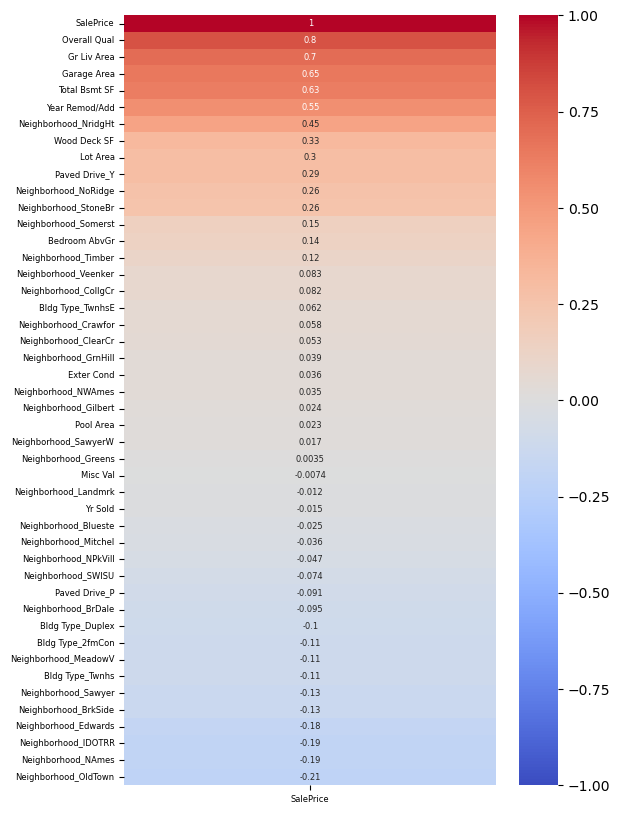

In [387]:
# Create a heatmap showing the correlations of each of the features in hte original dataset (init_data) against the sales price:
plt.figure(figsize=(6,10))
plt.xticks(size = 6)
plt.yticks(size = 6)          
sns.heatmap(init_data.corr()[['SalePrice']].sort_values(by = 'SalePrice', ascending = False),
            vmin = -1,
            vmax = 1,
            annot = True,
            annot_kws={"size":6},
            cmap = 'coolwarm'
           )

In [388]:
# Output a list of features where the corraltion magnitude is greater than 0.2:
init_data.corr()['SalePrice'][(init_data.corr()['SalePrice'] >= 0.15) | (init_data.corr()['SalePrice'] <= -0.15)].index

Index(['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Lot Area', 'Overall Qual',
       'Year Remod/Add', 'Gr Liv Area', 'Wood Deck SF', 'Neighborhood_Edwards',
       'Neighborhood_IDOTRR', 'Neighborhood_NAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Paved Drive_Y'],
      dtype='object')

Above:  Only Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', and 'Neighborhood_StoneBr' appear to have corraltions with the slae prace with magnitudes greater than 0.2.  These will be added back into the model.

In [389]:
data_2 = init_data[['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Lot Area', 'Overall Qual',
                    'Year Remod/Add', 'Gr Liv Area', 'Bedroom AbvGr', 'Wood Deck SF',
                    'Pool Area', 'Misc Val', 'Yr Sold', 'Exter Cond',
                    'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes', 'Neighborhood_NoRidge',
                    'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
                    'Bldg Type_2fmCon', 'Bldg Type_Duplex', 'Bldg Type_Twnhs',
                    'Bldg Type_TwnhsE', 'Paved Drive_P', 'Paved Drive_Y']]

In [390]:
X2 = data_2.drop(columns = 'SalePrice')
y2 = data_2['SalePrice']

In [391]:
model_metrics = model_metrics.merge(split_fit_metric_frame(X2, y2, 'data_2'), left_index=True, right_index=True)
model_metrics

,mod,data_1,data_2
R2_train,0.8621,0.8269,0.8556
R2_test,0.7976,0.7389,0.7856
RMSE_train,29492.0000,33043.0000,30177.0000
RMSE_test,35452.0000,40265.0000,36486.0000
mae_train,19786.0000,22611.0000,20319.0000
mae_test,20797.0000,23716.0000,21498.0000
cv_train_mean,0.8232,0.7921,0.8214
cv_train_1,0.8366,0.8321,0.8385
cv_train_2,0.8572,0.8141,0.8529
cv_train_3,0.7984,0.7651,0.8056


In [392]:
len(X2.columns)

26

In [393]:
data_3 = init_data[['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Lot Area', 'Overall Qual',
                    'Year Remod/Add', 'Gr Liv Area', 'Bedroom AbvGr', 'Wood Deck SF',
                    'Pool Area', 'Misc Val', 'Yr Sold', 'Exter Cond',
                    'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes', 'Neighborhood_NoRidge',
                    'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
                    'Bldg Type_2fmCon', 'Bldg Type_Duplex', 'Bldg Type_Twnhs',
                    'Bldg Type_TwnhsE', 'Paved Drive_P', 'Paved Drive_Y']].copy()

data_3[['Mas Vnr Area', 'Fireplaces', 'BsmtFin SF 1']] = train[['Mas Vnr Area', 'Fireplaces', 'BsmtFin SF 1']].copy()

In [394]:
data_3.info()

data_3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SalePrice             2051 non-null   int64  
 1   Total Bsmt SF         2051 non-null   float64
 2   Garage Area           2051 non-null   float64
 3   Lot Area              2051 non-null   int64  
 4   Overall Qual          2051 non-null   int64  
 5   Year Remod/Add        2051 non-null   int64  
 6   Gr Liv Area           2051 non-null   int64  
 7   Bedroom AbvGr         2051 non-null   int64  
 8   Wood Deck SF          2051 non-null   int64  
 9   Pool Area             2051 non-null   int64  
 10  Misc Val              2051 non-null   int64  
 11  Yr Sold               2051 non-null   int64  
 12  Exter Cond            2051 non-null   int64  
 13  Neighborhood_Edwards  2051 non-null   uint8  
 14  Neighborhood_IDOTRR   2051 non-null   uint8  
 15  Neighborhood_NAmes   

,SalePrice,Total Bsmt SF,Garage Area,Lot Area,Overall Qual,Year Remod/Add,Gr Liv Area,Bedroom AbvGr,Wood Deck SF,Pool Area,...,Neighborhood_StoneBr,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Paved Drive_P,Paved Drive_Y,Mas Vnr Area,Fireplaces,BsmtFin SF 1
0,130500,725.0,475.0,13517,6,2005,1479,3,0,0,...,0,0,0,0,0,0,1,289.0,0,533.0
1,220000,913.0,559.0,11492,7,1997,2122,4,0,0,...,0,0,0,0,0,0,1,132.0,1,637.0
2,109000,1057.0,246.0,7922,5,2007,1057,3,0,0,...,0,0,0,0,0,0,1,0.0,0,731.0
3,174000,384.0,400.0,9802,5,2007,1444,3,100,0,...,0,0,0,0,0,0,1,0.0,0,0.0
4,138500,676.0,484.0,14235,6,1993,1445,3,0,0,...,0,0,0,0,0,0,0,0.0,0,0.0


In [395]:
# There are a few samples with have null values for 'Mas Vnr Area' and 'BsmtFin SF 1'.  These can likely be iumputed with zeros.
#  It's not a bad assumption that null vlues for masonry and finished basements would indicate that neither exist in the home, and the square footage for each is 0.
data_3.fillna(0, inplace=True)
data_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SalePrice             2051 non-null   int64  
 1   Total Bsmt SF         2051 non-null   float64
 2   Garage Area           2051 non-null   float64
 3   Lot Area              2051 non-null   int64  
 4   Overall Qual          2051 non-null   int64  
 5   Year Remod/Add        2051 non-null   int64  
 6   Gr Liv Area           2051 non-null   int64  
 7   Bedroom AbvGr         2051 non-null   int64  
 8   Wood Deck SF          2051 non-null   int64  
 9   Pool Area             2051 non-null   int64  
 10  Misc Val              2051 non-null   int64  
 11  Yr Sold               2051 non-null   int64  
 12  Exter Cond            2051 non-null   int64  
 13  Neighborhood_Edwards  2051 non-null   uint8  
 14  Neighborhood_IDOTRR   2051 non-null   uint8  
 15  Neighborhood_NAmes   

In [396]:
X3 = data_3.drop(columns = 'SalePrice')
y3 = data_3['SalePrice']

In [397]:
model_metrics = model_metrics.merge(split_fit_metric_frame(X3, y3, 'data_3'), left_index=True, right_index=True)
model_metrics

,mod,data_1,data_2,data_3
R2_train,0.8621,0.8269,0.8556,0.8743
R2_test,0.7976,0.7389,0.7856,0.7769
RMSE_train,29492.0000,33043.0000,30177.0000,28155.0000
RMSE_test,35452.0000,40265.0000,36486.0000,37221.0000
mae_train,19786.0000,22611.0000,20319.0000,18457.0000
mae_test,20797.0000,23716.0000,21498.0000,20792.0000
cv_train_mean,0.8232,0.7921,0.8214,0.8358
cv_train_1,0.8366,0.8321,0.8385,0.8737
cv_train_2,0.8572,0.8141,0.8529,0.8802
cv_train_3,0.7984,0.7651,0.8056,0.8111


## 4.2 - DIfferent Modeling Strategy

In [398]:
prelim_features

Index(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area',
       'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Yr Blt',
       'Garage Cars', 'Garage Area', 'SalePrice'],
      dtype='object')

In [406]:
data_4 = train[prelim_features].drop(columns = 'Garage Yr Blt')
data_4.head()
data_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Overall Qual    2051 non-null   int64  
 1   Year Built      2051 non-null   int64  
 2   Year Remod/Add  2051 non-null   int64  
 3   Mas Vnr Area    2029 non-null   float64
 4   BsmtFin SF 1    2050 non-null   float64
 5   Total Bsmt SF   2050 non-null   float64
 6   1st Flr SF      2051 non-null   int64  
 7   Gr Liv Area     2051 non-null   int64  
 8   Full Bath       2051 non-null   int64  
 9   TotRms AbvGrd   2051 non-null   int64  
 10  Fireplaces      2051 non-null   int64  
 11  Garage Cars     2050 non-null   float64
 12  Garage Area     2050 non-null   float64
 13  SalePrice       2051 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 224.5 KB


In [408]:
# Impute zeros for all null values using same logic as previously:  IF it's an NaN, assume the house does not have that feature and it's equal to 0.
data_4.fillna(0, inplace = True)
data_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Overall Qual    2051 non-null   int64  
 1   Year Built      2051 non-null   int64  
 2   Year Remod/Add  2051 non-null   int64  
 3   Mas Vnr Area    2051 non-null   float64
 4   BsmtFin SF 1    2051 non-null   float64
 5   Total Bsmt SF   2051 non-null   float64
 6   1st Flr SF      2051 non-null   int64  
 7   Gr Liv Area     2051 non-null   int64  
 8   Full Bath       2051 non-null   int64  
 9   TotRms AbvGrd   2051 non-null   int64  
 10  Fireplaces      2051 non-null   int64  
 11  Garage Cars     2051 non-null   float64
 12  Garage Area     2051 non-null   float64
 13  SalePrice       2051 non-null   int64  
dtypes: float64(5), int64(9)
memory usage: 224.5 KB


In [410]:
X4 = data_4.drop(columns = 'SalePrice')
y4 = data_4['SalePrice']

In [411]:
model_metrics = model_metrics.merge(split_fit_metric_frame(X4, y4, 'data_4'), left_index=True, right_index=True)
model_metrics

,mod,data_1,data_2,data_3,data_4
R2_train,0.8621,0.8269,0.8556,0.8743,0.8262
R2_test,0.7976,0.7389,0.7856,0.7769,0.7521
RMSE_train,29492.0000,33043.0000,30177.0000,28155.0000,33114.0000
RMSE_test,35452.0000,40265.0000,36486.0000,37221.0000,39233.0000
mae_train,19786.0000,22611.0000,20319.0000,18457.0000,21256.0000
mae_test,20797.0000,23716.0000,21498.0000,20792.0000,22618.0000
cv_train_mean,0.8232,0.7921,0.8214,0.8358,0.8188
cv_train_1,0.8366,0.8321,0.8385,0.8737,0.8590
cv_train_2,0.8572,0.8141,0.8529,0.8802,0.8415
cv_train_3,0.7984,0.7651,0.8056,0.8111,0.8369


## 4.3 - Polynomial features

In [413]:
poly = PolynomialFeatures(include_bias=False)

In [414]:
X4_poly = poly.fit_transform(X4)

In [415]:
X4_poly.shape

(2051, 104)

In [416]:
poly.get_feature_names_out(X4.columns)

array(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area',
       'Full Bath', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars',
       'Garage Area', 'Overall Qual^2', 'Overall Qual Year Built',
       'Overall Qual Year Remod/Add', 'Overall Qual Mas Vnr Area',
       'Overall Qual BsmtFin SF 1', 'Overall Qual Total Bsmt SF',
       'Overall Qual 1st Flr SF', 'Overall Qual Gr Liv Area',
       'Overall Qual Full Bath', 'Overall Qual TotRms AbvGrd',
       'Overall Qual Fireplaces', 'Overall Qual Garage Cars',
       'Overall Qual Garage Area', 'Year Built^2',
       'Year Built Year Remod/Add', 'Year Built Mas Vnr Area',
       'Year Built BsmtFin SF 1', 'Year Built Total Bsmt SF',
       'Year Built 1st Flr SF', 'Year Built Gr Liv Area',
       'Year Built Full Bath', 'Year Built TotRms AbvGrd',
       'Year Built Fireplaces', 'Year Built Garage Cars',
       'Year Built Garage Area', 'Year Remod/Add^2',
   

In [435]:
X4_poly_corr = pd.DataFrame(X4_poly, columns=poly.get_feature_names_out(X4.columns))

In [436]:
X4_poly_corr['SalePrice'] = y4
X4_poly_corr.head()

,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,...,TotRms AbvGrd Fireplaces,TotRms AbvGrd Garage Cars,TotRms AbvGrd Garage Area,Fireplaces^2,Fireplaces Garage Cars,Fireplaces Garage Area,Garage Cars^2,Garage Cars Garage Area,Garage Area^2,SalePrice
0,6.0,1976.0,2005.0,289.0,533.0,725.0,725.0,1479.0,2.0,6.0,...,0.0,12.0,2850.0,0.0,0.0,0.0,4.0,950.0,225625.0,130500
1,7.0,1996.0,1997.0,132.0,637.0,913.0,913.0,2122.0,2.0,8.0,...,8.0,16.0,4472.0,1.0,2.0,559.0,4.0,1118.0,312481.0,220000
2,5.0,1953.0,2007.0,0.0,731.0,1057.0,1057.0,1057.0,1.0,5.0,...,0.0,5.0,1230.0,0.0,0.0,0.0,1.0,246.0,60516.0,109000
3,5.0,2006.0,2007.0,0.0,0.0,384.0,744.0,1444.0,2.0,7.0,...,0.0,14.0,2800.0,0.0,0.0,0.0,4.0,800.0,160000.0,174000
4,6.0,1900.0,1993.0,0.0,0.0,676.0,831.0,1445.0,2.0,6.0,...,0.0,12.0,2904.0,0.0,0.0,0.0,4.0,968.0,234256.0,138500


In [463]:
# Find correlations where magnitude is greater than 0.6
X4_poly_corr.corr()[['SalePrice']][abs(X4_poly_corr.corr()['SalePrice']) >= 0.65].sort_values(by = "SalePrice")

,SalePrice
Total Bsmt SF TotRms AbvGrd,0.650758
Year Remod/Add Garage Cars,0.656051
Year Remod/Add Garage Area,0.658191
Year Built Garage Cars,0.658688
Year Built Garage Area,0.661478
Garage Cars^2,0.664522
Gr Liv Area Full Bath,0.682967
1st Flr SF Full Bath,0.686567
Garage Cars Garage Area,0.690596
Total Bsmt SF Garage Area,0.692389


In [460]:
features_5 = X4_poly_corr.corr()[['SalePrice']][abs(X4_poly_corr.corr()['SalePrice']) >= 0.65].index

In [457]:
data_5_poly = X4_poly_corr[features_5]
data_5_poly

,Overall Qual,Gr Liv Area,Overall Qual^2,Overall Qual Year Built,Overall Qual Year Remod/Add,Overall Qual Total Bsmt SF,Overall Qual 1st Flr SF,Overall Qual Gr Liv Area,Overall Qual Full Bath,Overall Qual TotRms AbvGrd,...,Gr Liv Area Full Bath,Gr Liv Area Garage Cars,Gr Liv Area Garage Area,Full Bath Garage Cars,Full Bath Garage Area,TotRms AbvGrd Garage Cars,TotRms AbvGrd Garage Area,Garage Cars^2,Garage Cars Garage Area,SalePrice
0,6.0,1479.0,36.0,11856.0,12030.0,4350.0,4350.0,8874.0,12.0,36.0,...,2958.0,2958.0,702525.0,4.0,950.0,12.0,2850.0,4.0,950.0,130500
1,7.0,2122.0,49.0,13972.0,13979.0,6391.0,6391.0,14854.0,14.0,56.0,...,4244.0,4244.0,1186198.0,4.0,1118.0,16.0,4472.0,4.0,1118.0,220000
2,5.0,1057.0,25.0,9765.0,10035.0,5285.0,5285.0,5285.0,5.0,25.0,...,1057.0,1057.0,260022.0,1.0,246.0,5.0,1230.0,1.0,246.0,109000
3,5.0,1444.0,25.0,10030.0,10035.0,1920.0,3720.0,7220.0,10.0,35.0,...,2888.0,2888.0,577600.0,4.0,800.0,14.0,2800.0,4.0,800.0,174000
4,6.0,1445.0,36.0,11400.0,11958.0,4056.0,4986.0,8670.0,12.0,36.0,...,2890.0,2890.0,699380.0,4.0,968.0,12.0,2904.0,4.0,968.0,138500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,8.0,1728.0,64.0,16056.0,16056.0,15072.0,13824.0,13824.0,16.0,56.0,...,3456.0,3456.0,898560.0,4.0,1040.0,14.0,3640.0,4.0,1040.0,298751
2047,4.0,861.0,16.0,7760.0,7800.0,3444.0,3444.0,3444.0,4.0,16.0,...,861.0,1722.0,464079.0,2.0,539.0,8.0,2156.0,4.0,1078.0,82500
2048,6.0,1913.0,36.0,11568.0,11700.0,5376.0,7032.0,11478.0,6.0,54.0,...,1913.0,3826.0,654246.0,2.0,342.0,18.0,3078.0,4.0,684.0,177000
2049,4.0,1200.0,16.0,7824.0,7824.0,4800.0,4800.0,4800.0,4.0,24.0,...,1200.0,1200.0,352800.0,1.0,294.0,6.0,1764.0,1.0,294.0,144000


In [458]:
X5 = data_5_poly.drop(columns = 'SalePrice')
y5 = data_5_poly['SalePrice']

model_metrics = model_metrics.merge(split_fit_metric_frame(X5, y5, 'data_5_poly'), left_index=True, right_index=True)
model_metrics

,mod,data_1,data_2,data_3,data_4,data_5_poly_x,data_5_poly_y,data_5_poly
R2_train,0.8621,0.8269,0.8556,0.8743,0.8262,0.8559,0.8093,0.8735
R2_test,0.7976,0.7389,0.7856,0.7769,0.7521,0.8670,0.7812,0.8697
RMSE_train,29492.0000,33043.0000,30177.0000,28155.0000,33114.0000,30150.0000,34683.0000,28250.0000
RMSE_test,35452.0000,40265.0000,36486.0000,37221.0000,39233.0000,28735.0000,36858.0000,28437.0000
mae_train,19786.0000,22611.0000,20319.0000,18457.0000,21256.0000,20346.0000,23125.0000,19571.0000
mae_test,20797.0000,23716.0000,21498.0000,20792.0000,22618.0000,20062.0000,21633.0000,20062.0000
cv_train_mean,0.8232,0.7921,0.8214,0.8358,0.8188,0.8013,0.8055,0.8135
cv_train_1,0.8366,0.8321,0.8385,0.8737,0.8590,0.8561,0.8275,0.8575
cv_train_2,0.8572,0.8141,0.8529,0.8802,0.8415,0.8314,0.8080,0.8554
cv_train_3,0.7984,0.7651,0.8056,0.8111,0.8369,0.8538,0.8329,0.8646


### Another one

In [465]:
data_3.columns

Index(['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Lot Area', 'Overall Qual',
       'Year Remod/Add', 'Gr Liv Area', 'Bedroom AbvGr', 'Wood Deck SF',
       'Pool Area', 'Misc Val', 'Yr Sold', 'Exter Cond',
       'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Bldg Type_2fmCon',
       'Bldg Type_Duplex', 'Bldg Type_Twnhs', 'Bldg Type_TwnhsE',
       'Paved Drive_P', 'Paved Drive_Y', 'Mas Vnr Area', 'Fireplaces',
       'BsmtFin SF 1'],
      dtype='object')

In [469]:
data_6 = data_3[['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Overall Qual',
       'Year Remod/Add', 'Gr Liv Area', 'Mas Vnr Area', 'Fireplaces']]
data_6_poly = poly.fit_transform(data_6.drop(columns = 'SalePrice'))
data_6_poly.shape

(2051, 35)

In [472]:
data_6.columns

Index(['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Overall Qual',
       'Year Remod/Add', 'Gr Liv Area', 'Mas Vnr Area', 'Fireplaces'],
      dtype='object')

In [476]:
poly.get_feature_names_out(data_6.columns.drop('SalePrice'))

array(['Total Bsmt SF', 'Garage Area', 'Overall Qual', 'Year Remod/Add',
       'Gr Liv Area', 'Mas Vnr Area', 'Fireplaces', 'Total Bsmt SF^2',
       'Total Bsmt SF Garage Area', 'Total Bsmt SF Overall Qual',
       'Total Bsmt SF Year Remod/Add', 'Total Bsmt SF Gr Liv Area',
       'Total Bsmt SF Mas Vnr Area', 'Total Bsmt SF Fireplaces',
       'Garage Area^2', 'Garage Area Overall Qual',
       'Garage Area Year Remod/Add', 'Garage Area Gr Liv Area',
       'Garage Area Mas Vnr Area', 'Garage Area Fireplaces',
       'Overall Qual^2', 'Overall Qual Year Remod/Add',
       'Overall Qual Gr Liv Area', 'Overall Qual Mas Vnr Area',
       'Overall Qual Fireplaces', 'Year Remod/Add^2',
       'Year Remod/Add Gr Liv Area', 'Year Remod/Add Mas Vnr Area',
       'Year Remod/Add Fireplaces', 'Gr Liv Area^2',
       'Gr Liv Area Mas Vnr Area', 'Gr Liv Area Fireplaces',
       'Mas Vnr Area^2', 'Mas Vnr Area Fireplaces', 'Fireplaces^2'],
      dtype=object)

In [478]:
data_6_poly = pd.DataFrame(data_6_poly, columns=poly.get_feature_names_out(data_6.columns.drop('SalePrice')))
data_6_poly.head()

,Total Bsmt SF,Garage Area,Overall Qual,Year Remod/Add,Gr Liv Area,Mas Vnr Area,Fireplaces,Total Bsmt SF^2,Total Bsmt SF Garage Area,Total Bsmt SF Overall Qual,...,Year Remod/Add^2,Year Remod/Add Gr Liv Area,Year Remod/Add Mas Vnr Area,Year Remod/Add Fireplaces,Gr Liv Area^2,Gr Liv Area Mas Vnr Area,Gr Liv Area Fireplaces,Mas Vnr Area^2,Mas Vnr Area Fireplaces,Fireplaces^2
0,725.0,475.0,6.0,2005.0,1479.0,289.0,0.0,525625.0,344375.0,4350.0,...,4020025.0,2965395.0,579445.0,0.0,2187441.0,427431.0,0.0,83521.0,0.0,0.0
1,913.0,559.0,7.0,1997.0,2122.0,132.0,1.0,833569.0,510367.0,6391.0,...,3988009.0,4237634.0,263604.0,1997.0,4502884.0,280104.0,2122.0,17424.0,132.0,1.0
2,1057.0,246.0,5.0,2007.0,1057.0,0.0,0.0,1117249.0,260022.0,5285.0,...,4028049.0,2121399.0,0.0,0.0,1117249.0,0.0,0.0,0.0,0.0,0.0
3,384.0,400.0,5.0,2007.0,1444.0,0.0,0.0,147456.0,153600.0,1920.0,...,4028049.0,2898108.0,0.0,0.0,2085136.0,0.0,0.0,0.0,0.0,0.0
4,676.0,484.0,6.0,1993.0,1445.0,0.0,0.0,456976.0,327184.0,4056.0,...,3972049.0,2879885.0,0.0,0.0,2088025.0,0.0,0.0,0.0,0.0,0.0


In [479]:
X6_poly = data_6_poly
y6_poly = data_6['SalePrice']

model_metrics = model_metrics.merge(split_fit_metric_frame(X6_poly, y6_poly, 'data_6_poly'), left_index=True, right_index=True)
model_metrics

,mod,data_1,data_2,data_3,data_4,data_5_poly_x,data_5_poly_y,data_5_poly,data_6_poly
R2_train,0.8621,0.8269,0.8556,0.8743,0.8262,0.8559,0.8093,0.8735,0.8817
R2_test,0.7976,0.7389,0.7856,0.7769,0.7521,0.8670,0.7812,0.8697,0.8715
RMSE_train,29492.0000,33043.0000,30177.0000,28155.0000,33114.0000,30150.0000,34683.0000,28250.0000,27314.0000
RMSE_test,35452.0000,40265.0000,36486.0000,37221.0000,39233.0000,28735.0000,36858.0000,28437.0000,28241.0000
mae_train,19786.0000,22611.0000,20319.0000,18457.0000,21256.0000,20346.0000,23125.0000,19571.0000,19080.0000
mae_test,20797.0000,23716.0000,21498.0000,20792.0000,22618.0000,20062.0000,21633.0000,20062.0000,19799.0000
cv_train_mean,0.8232,0.7921,0.8214,0.8358,0.8188,0.8013,0.8055,0.8135,0.7955
cv_train_1,0.8366,0.8321,0.8385,0.8737,0.8590,0.8561,0.8275,0.8575,0.8737
cv_train_2,0.8572,0.8141,0.8529,0.8802,0.8415,0.8314,0.8080,0.8554,0.8605
cv_train_3,0.7984,0.7651,0.8056,0.8111,0.8369,0.8538,0.8329,0.8646,0.8517


In [481]:
X7_poly_nbr = X6_poly
X7_poly_nbr[['Neighborhood_Edwards', 'Neighborhood_IDOTRR', 
             'Neighborhood_NAmes', 'Neighborhood_NoRidge',
             'Neighborhood_NridgHt', 'Neighborhood_OldTown', 
             'Neighborhood_Somerst', 'Neighborhood_StoneBr']] = init_data[['Neighborhood_Edwards', 'Neighborhood_IDOTRR',
                                                                           'Neighborhood_NAmes', 'Neighborhood_NoRidge',
                                                                           'Neighborhood_NridgHt', 'Neighborhood_OldTown',
                                                                           'Neighborhood_Somerst', 'Neighborhood_StoneBr']]
X7_poly_nbr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Total Bsmt SF                 2051 non-null   float64
 1   Garage Area                   2051 non-null   float64
 2   Overall Qual                  2051 non-null   float64
 3   Year Remod/Add                2051 non-null   float64
 4   Gr Liv Area                   2051 non-null   float64
 5   Mas Vnr Area                  2051 non-null   float64
 6   Fireplaces                    2051 non-null   float64
 7   Total Bsmt SF^2               2051 non-null   float64
 8   Total Bsmt SF Garage Area     2051 non-null   float64
 9   Total Bsmt SF Overall Qual    2051 non-null   float64
 10  Total Bsmt SF Year Remod/Add  2051 non-null   float64
 11  Total Bsmt SF Gr Liv Area     2051 non-null   float64
 12  Total Bsmt SF Mas Vnr Area    2051 non-null   float64
 13  Tot

In [482]:
model_metrics = model_metrics.merge(split_fit_metric_frame(X7_poly_nbr, y6_poly, 'data_7_poly_nbr'), left_index=True, right_index=True)
model_metrics

,mod,data_1,data_2,data_3,data_4,data_5_poly_x,data_5_poly_y,data_5_poly,data_6_poly,data_7_poly_nbr
R2_train,0.8621,0.8269,0.8556,0.8743,0.8262,0.8559,0.8093,0.8735,0.8817,0.8902
R2_test,0.7976,0.7389,0.7856,0.7769,0.7521,0.8670,0.7812,0.8697,0.8715,0.8760
RMSE_train,29492.0000,33043.0000,30177.0000,28155.0000,33114.0000,30150.0000,34683.0000,28250.0000,27314.0000,26319.0000
RMSE_test,35452.0000,40265.0000,36486.0000,37221.0000,39233.0000,28735.0000,36858.0000,28437.0000,28241.0000,27749.0000
mae_train,19786.0000,22611.0000,20319.0000,18457.0000,21256.0000,20346.0000,23125.0000,19571.0000,19080.0000,18437.0000
mae_test,20797.0000,23716.0000,21498.0000,20792.0000,22618.0000,20062.0000,21633.0000,20062.0000,19799.0000,19569.0000
cv_train_mean,0.8232,0.7921,0.8214,0.8358,0.8188,0.8013,0.8055,0.8135,0.7955,0.8067
cv_train_1,0.8366,0.8321,0.8385,0.8737,0.8590,0.8561,0.8275,0.8575,0.8737,0.8732
cv_train_2,0.8572,0.8141,0.8529,0.8802,0.8415,0.8314,0.8080,0.8554,0.8605,0.8740
cv_train_3,0.7984,0.7651,0.8056,0.8111,0.8369,0.8538,0.8329,0.8646,0.8517,0.8614


In [ ]:
data_3 = init_data[['SalePrice', 'Total Bsmt SF', 'Garage Area', 'Lot Area', 'Overall Qual',
                    'Year Remod/Add', 'Gr Liv Area', 'Bedroom AbvGr', 'Wood Deck SF',
                    'Pool Area', 'Misc Val', 'Yr Sold', 'Exter Cond',
                    'Neighborhood_Edwards', 'Neighborhood_IDOTRR', 'Neighborhood_NAmes', 'Neighborhood_NoRidge',
                    'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
                    'Bldg Type_2fmCon', 'Bldg Type_Duplex', 'Bldg Type_Twnhs',
                    'Bldg Type_TwnhsE', 'Paved Drive_P', 'Paved Drive_Y']].copy()

data_3[['Mas Vnr Area', 'Fireplaces', 'BsmtFin SF 1']] = train[['Mas Vnr Area', 'Fireplaces', 'BsmtFin SF 1']].copy()

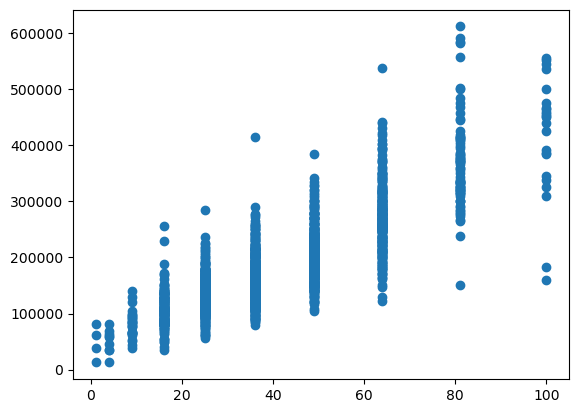

In [441]:
plt.scatter(X4_poly_corr['Overall Qual^2'], y4)

___
# Appendix A - Relevant Outside Research Conclusions
Below are a list of conclusions derivded from research sources found on the internet that are pertinent to the analysis above:
* The garage does NOT count towards total sqaure footage: https://raleighrealtyhomes.com/blog/measure-square-footage/#:~:text=Does%20the%20garage%20count%20in,converted%20into%20a%20living%20space.
* The basement does NOT count towards the total square footage:  https://www.realtor.com/advice/buy/does-basement-count-square-footage-of-a-home/#:~:text=Does%20a%20basement%20count%20toward,that%20means%20below%20ground%20level.
* Townhouse end units worth more:  https://firsthousecoach.com/is-an-end-unit-townhouse-worth-more/#:~:text=The%20Differences%20Between%20An%20End%20Unit%20VS.&text=More%20than%20likely%2C%20you%20will,be%20desirable%20for%20many%20people.
* Importance of Neighborhood in home value:  https://www.opendoor.com/articles/factors-that-influence-home-value



<font color= 'red'>STRING OF TEXT

___
# JUNK

In [399]:
train['Yr Sold'].value_counts()

2007    498
2009    446
2006    438
2008    435
2010    234
Name: Yr Sold, dtype: int64

In [400]:
#init_data[['Utilities', 'Neighborhood', 'Bldg Type', 'House Style', 'Paved Drive']].unique()

# init_data['Utilities'].unique()

unique_var = pd.DataFrame(columns=['Neighborhood', 'Bldg Type', 'Paved Drive'])

# for i in ['Utilities', 'Neighborhood', 'Bldg Type', 'House Style', 'Paved Drive']:
#     unique_var.merge(pd.Series(init_data[i].unique(), name = i), 'outer')

# df = pd.DataFrame()


# Sourece for unique:  https://sparkbyexamples.com/pandas/pandas-find-unique-values-from-columns/#:~:text=You%20can%20get%20unique%20values,to%20get%20from%20multiple%20columns.
# Also used doc string for code below

# pd.Series(init_data['Utilities'].unique())

pd.Series(init_data['Paved Drive'].unique(), name = 'Paved Drive').index

unique_var = unique_var.merge(pd.Series(init_data['Paved Drive'].unique(), name = 'Paved Drive'), 'outer', left_index = True, right_index = True, copy = False)
unique_var = unique_var.merge(pd.Series(init_data['Neighborhood'].unique(), name = 'Neighborhood'), 'outer', left_index = True, right_index = True, copy = False)


unique_var

KeyError: 'Paved Drive'

In [ ]:
sum(abs(y_init_train - preds_train))/len(preds_train), sum(abs(y_init_test - preds_test))/len(preds_test)

In [ ]:
def fit_metric_frame(mod_name):
    # global exec('{mod_name}')
    # exec('{mod_name}' + ' =18')
    global funtime
    funtime = 80
    
    # Calling global source(s):  https://www.programiz.com/python-programming/global-keyword
    # https://www.w3schools.com/python/python_variables_global.asp
    
    # exec('global' + f' {mod_name}')
    # exec(f'{mod_name}' + '=26')
    # calling exec source:  https://stackoverflow.com/questions/11553721/using-a-string-variable-as-a-variable-name


In [ ]:
fit_metric_frame('cannon')

In [ ]:
cannon

In [ ]:
%whos

In [ ]:
funtime.merge(split_fit_metric_frame(X_init, y_init, 'modZZ'), left_index=True, right_index=True)

In [ ]:
def testing(name):
    globals()[f'{name}_is_a_man'] = 74

In [ ]:
testing('Dan')

In [ ]:
Dan_is_a_man